<a href="https://colab.research.google.com/github/PriyankaJha2002/Kaggle-Tabular-Playground-Series---Jul-2022/blob/main/B21EE052_B21EE049_minor_project_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.filterwarnings(action= 'ignore')

**Read the csv file and drop irrelevant columns like 'id'**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
train = pd.read_csv('data.csv')
train.shape


(98000, 30)

In [ ]:
train.drop('id',axis=1,inplace=True)
train.shape

(98000, 29)

**Feature Selection**

<Axes: >

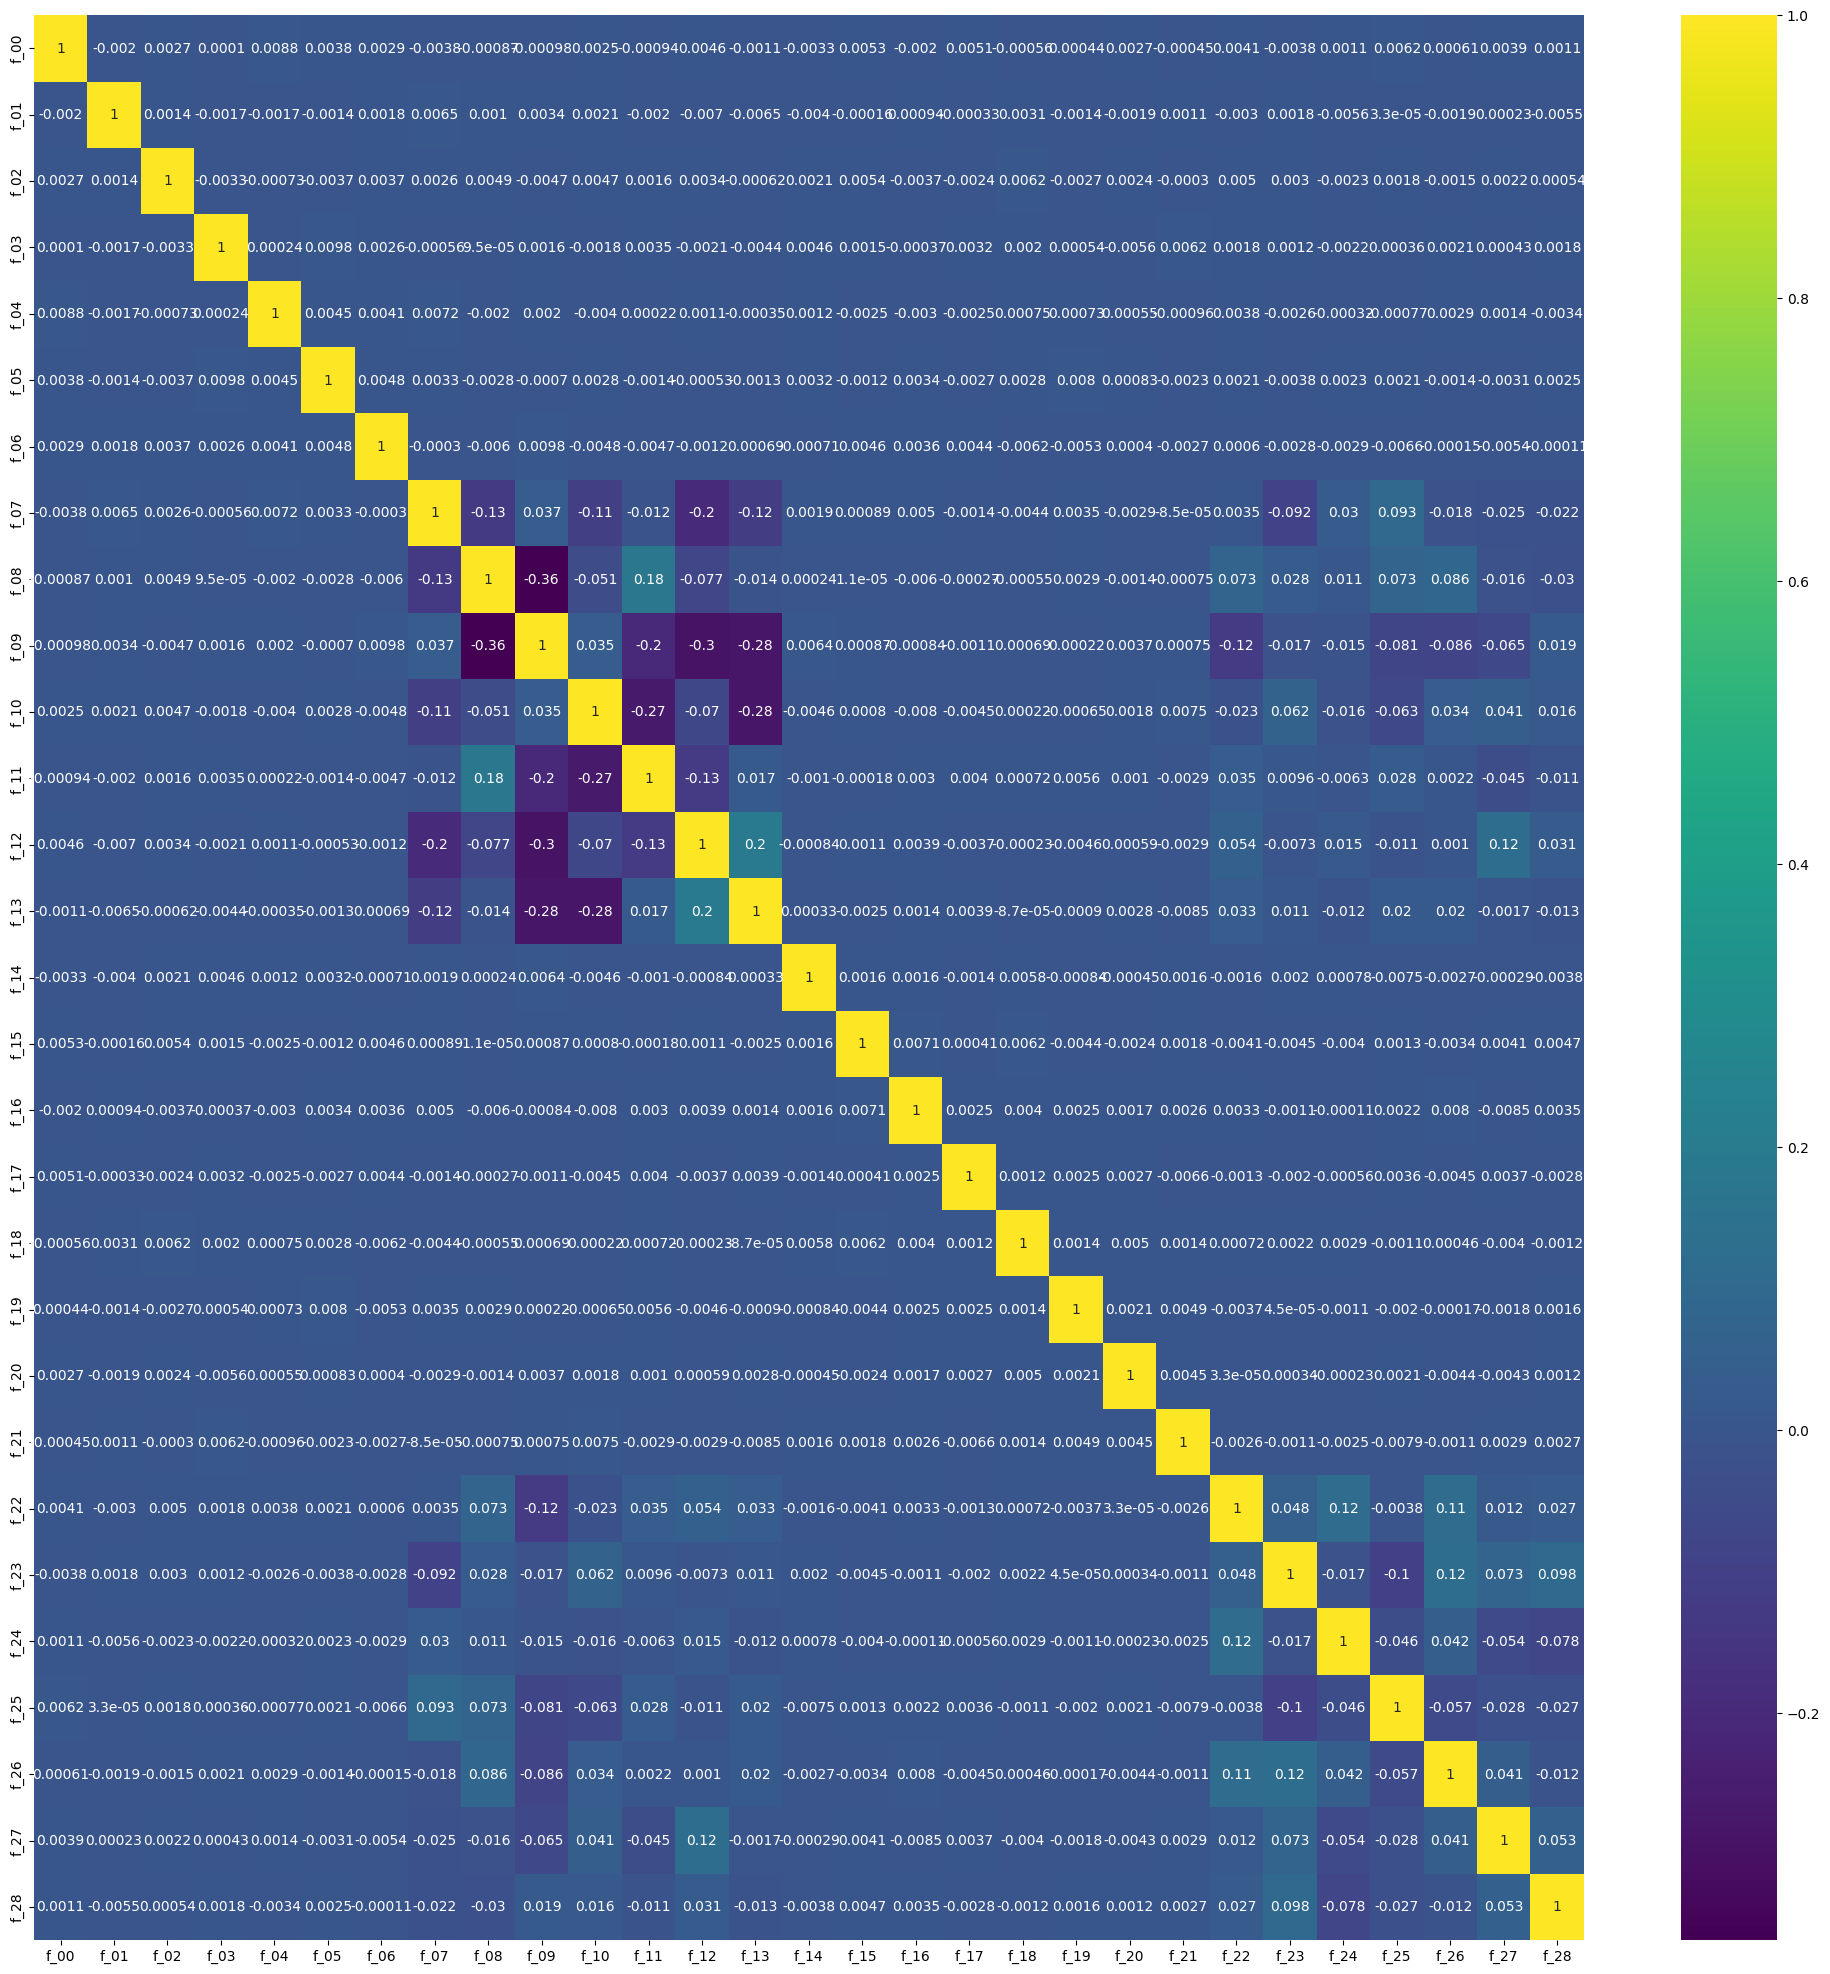

In [ ]:
plt.figure(figsize=(25,25))
sns.heatmap(train.corr(),annot=True,cmap='viridis')

**From the heat map we can see that the relevant features are [f_7 to f_13] and [f_22 to f_28]**

**EDA**

Numerical feature

In [ ]:
num_feature = [feature for feature in train.columns if train[feature].dtype != 'o']
print('Number of Numerical features:' ,len(num_feature))

Number of Numerical features: 29


In [ ]:
#Discrete numerical features
disc_num_feature = [feature for feature in num_feature if len(train[feature].unique())<100]
print('Number of Discrete features:',len(disc_num_feature))

Number of Discrete features: 7


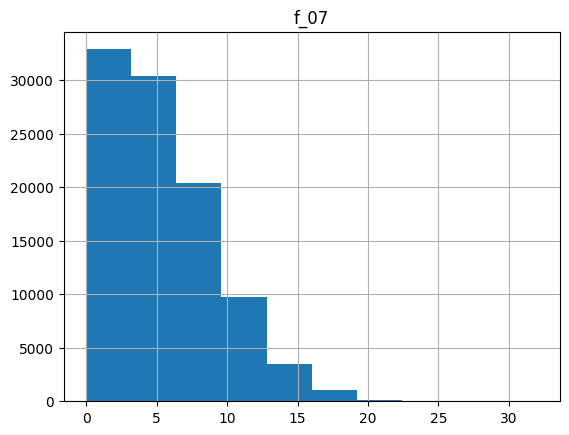

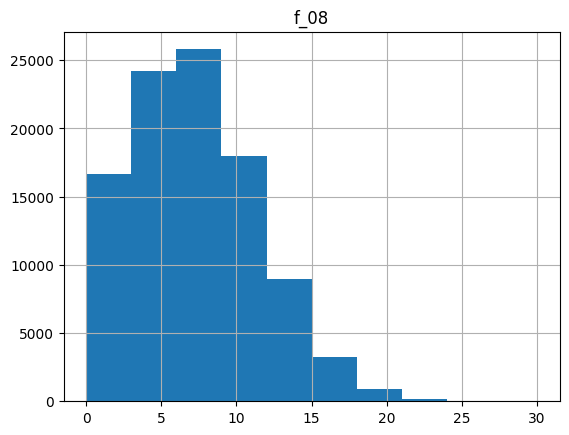

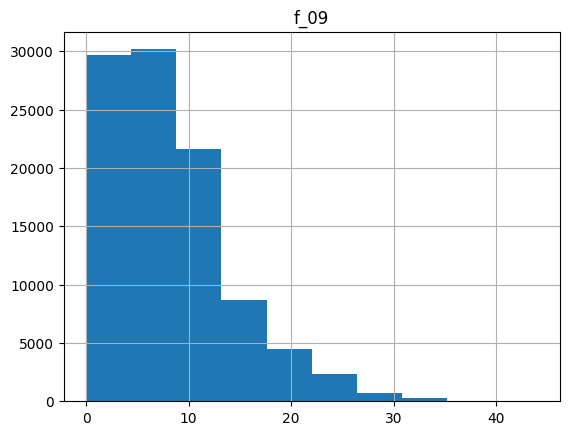

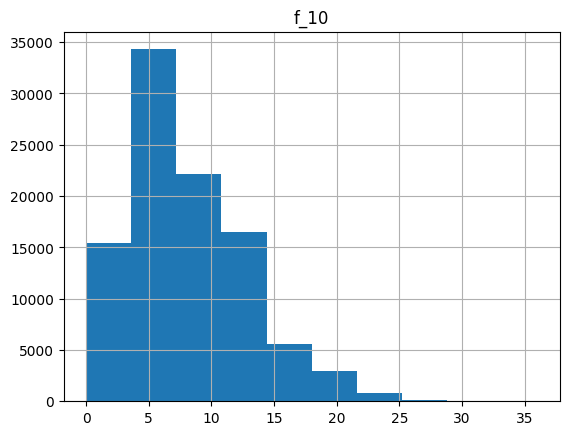

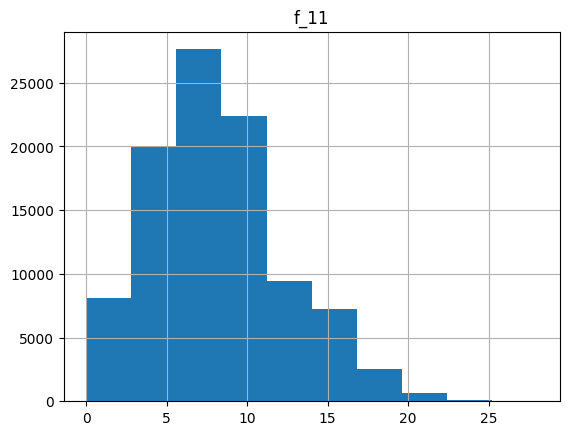

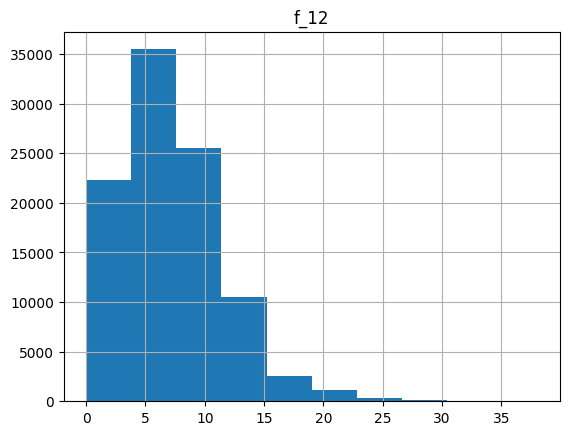

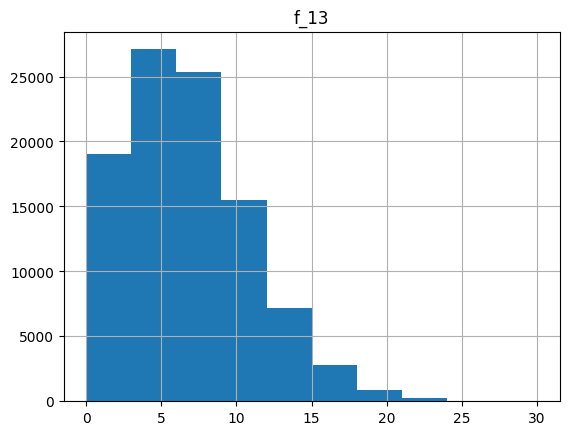

In [ ]:
for feature in disc_num_feature:
    data = train.copy()
    data[feature].hist()
    plt.title(feature)
    plt.show()

In [ ]:
#continuous numerical features

cont_num_feature = [feature for feature in num_feature if feature not in disc_num_feature]

print("Number of Continuous features: ",len(cont_num_feature))

Number of Continuous features:  22


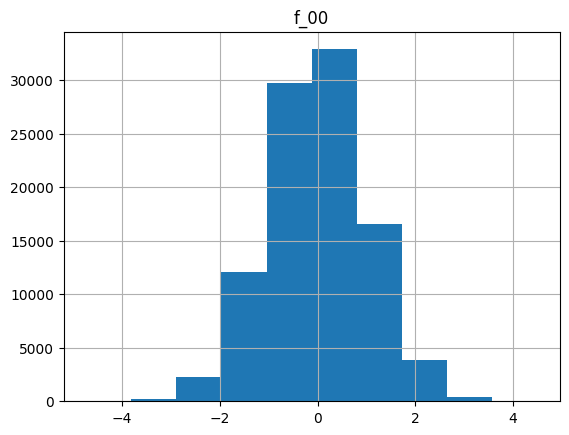

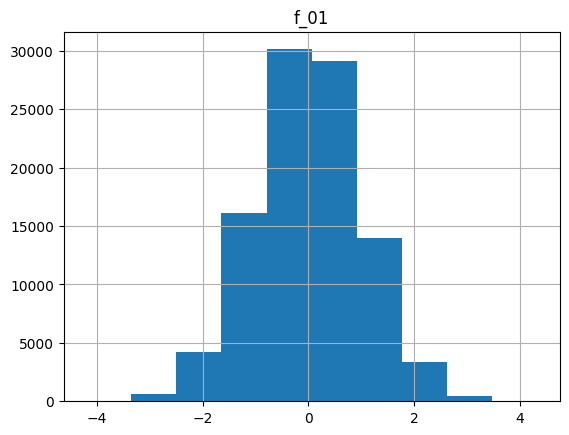

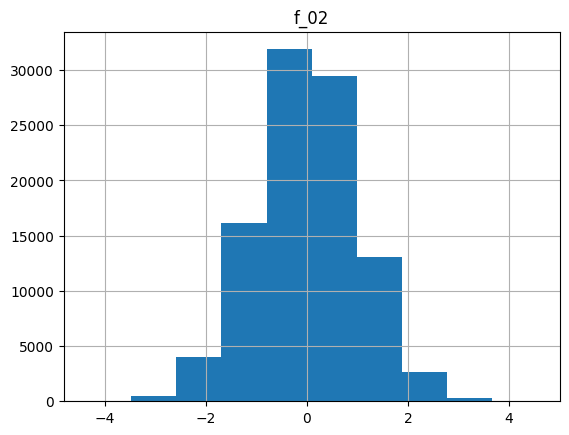

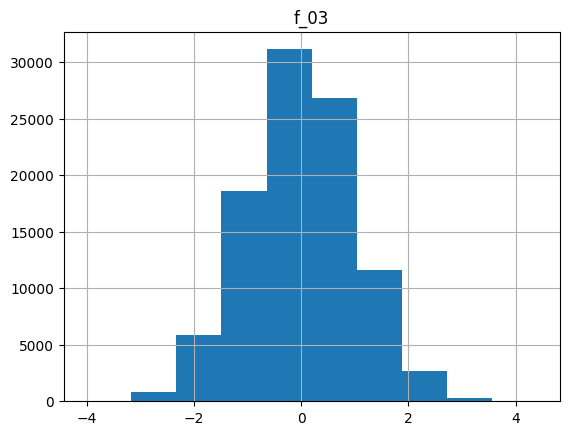

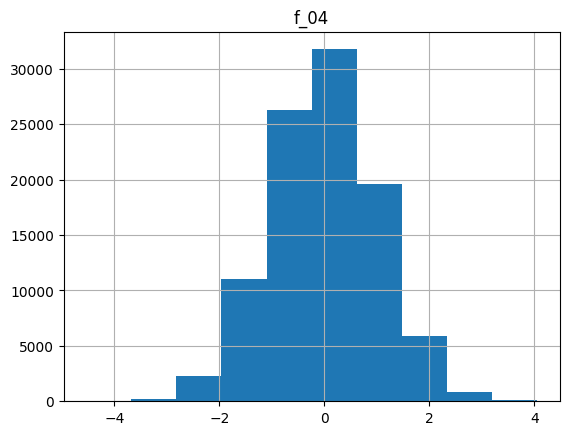

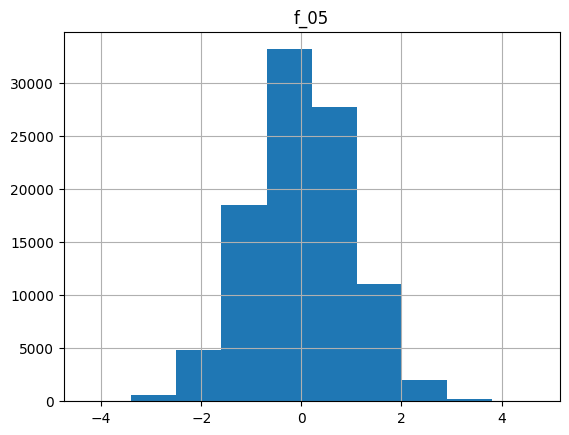

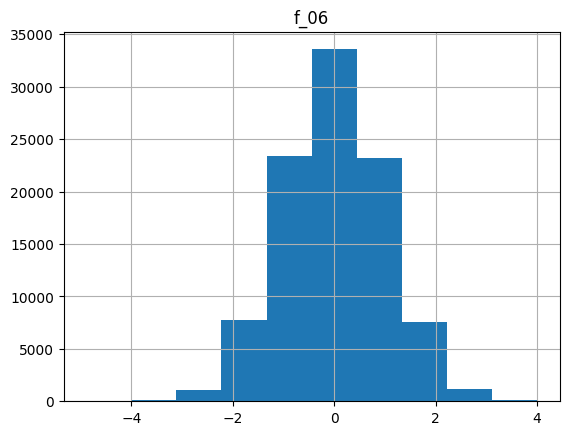

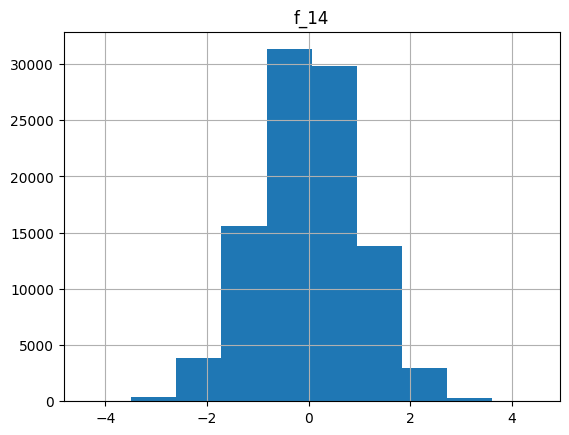

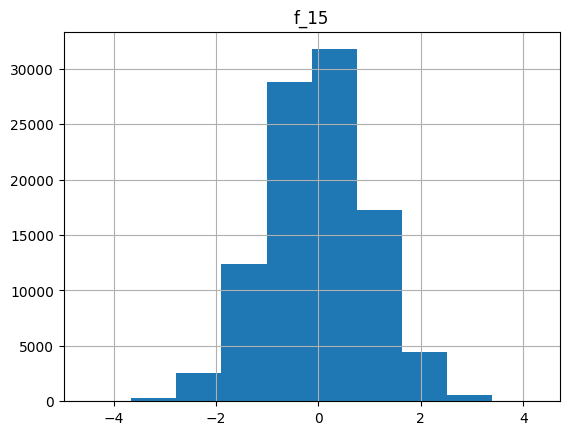

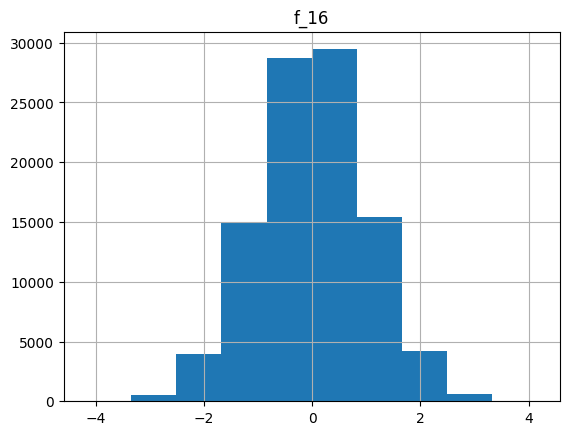

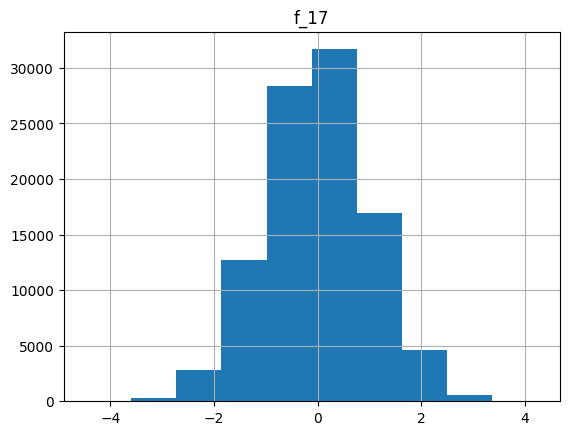

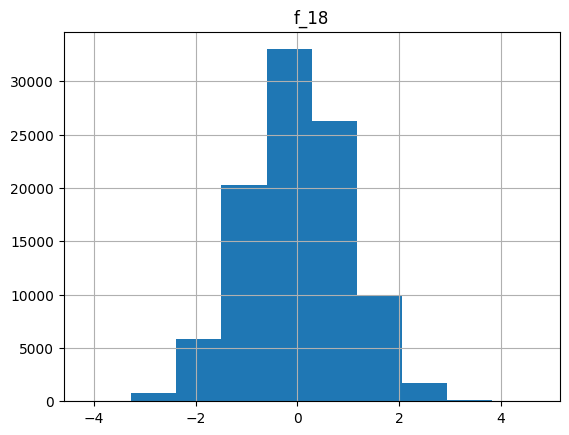

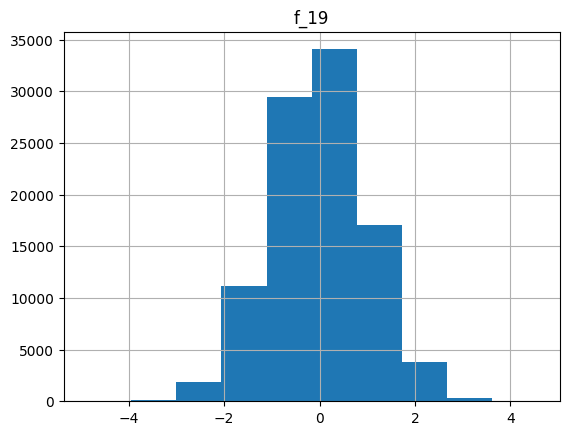

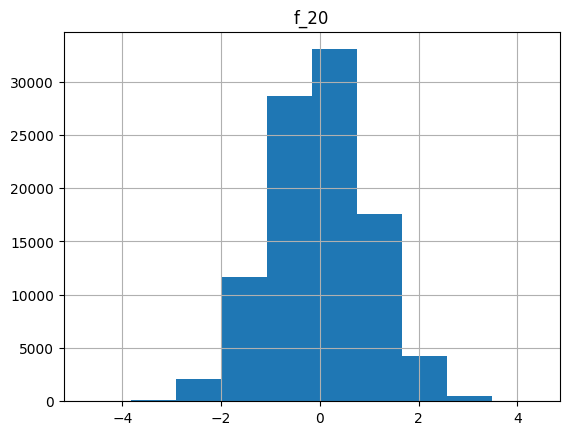

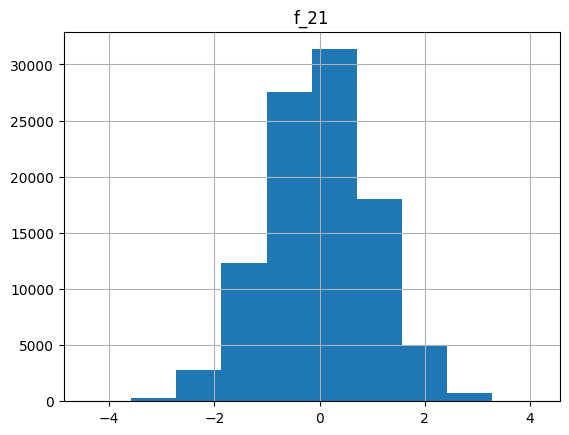

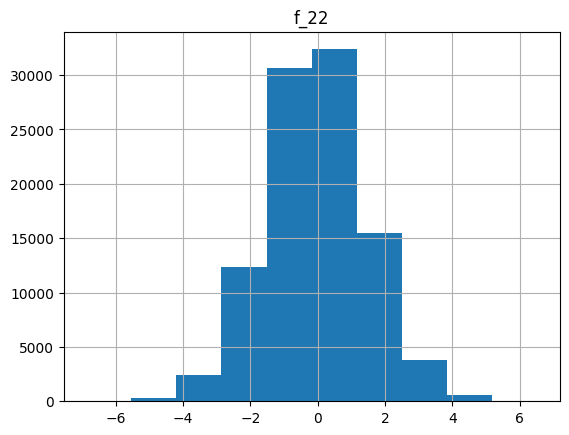

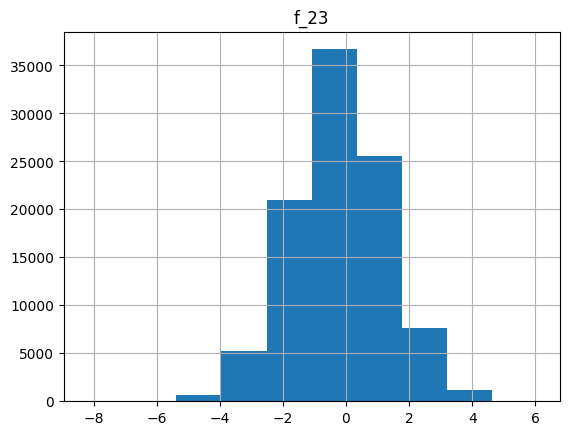

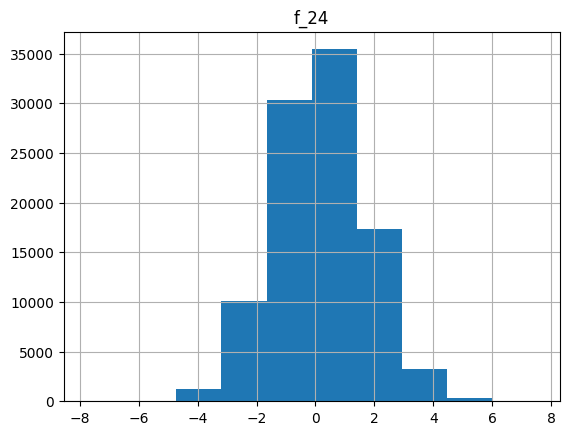

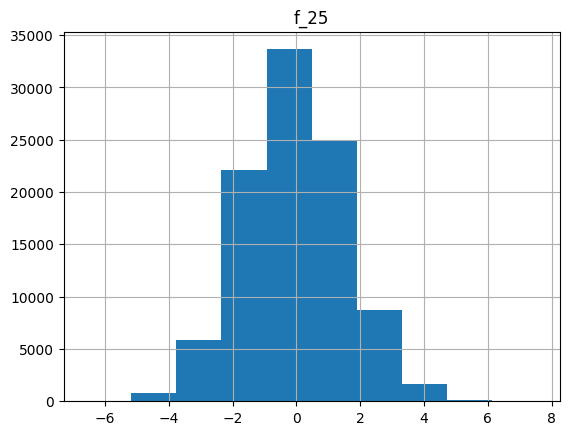

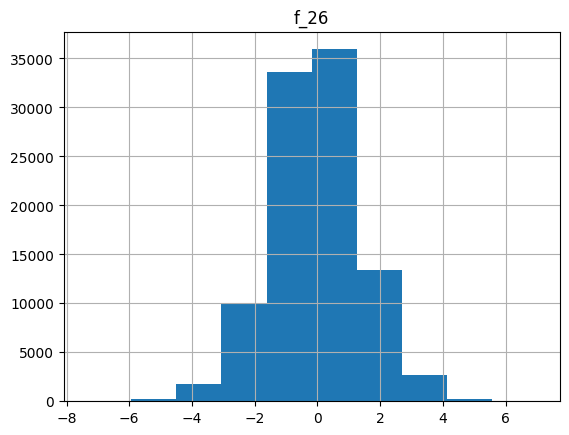

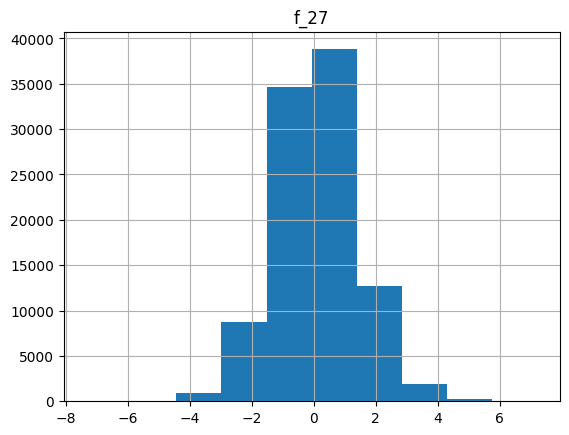

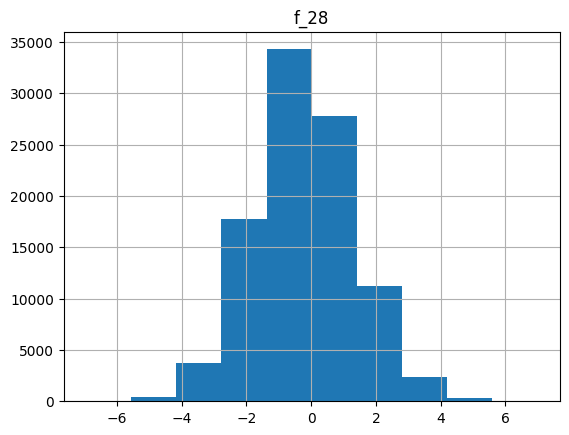

In [ ]:
for feature in cont_num_feature:
    data = train.copy()
    data[feature].hist()
    plt.title(feature)
    plt.show()

**Feature engineering**

In [ ]:
sum(train.isna().sum())

0

**Create test variable as copy of train because we are going to remove outlier**

In [ ]:
test = train.copy()

**Outlier Removing**


**Handling Rare values in discrete numerical features**

In [ ]:
train['f_07'].value_counts()

4     10797
3     10728
5     10337
2      9861
6      9239
7      8197
1      7574
8      6743
9      5428
0      4717
10     4275
11     3182
12     2252
13     1633
14     1143
15      706
16      440
17      273
18      198
19      108
20       70
21       35
22       31
23       10
25        7
24        7
26        2
29        2
27        2
30        1
28        1
32        1
Name: f_07, dtype: int64

In [ ]:
# Handle outliers
for col in disc_num_feature:
    # Calculate the interquartile range (IQR)
    Q1 = train[col].quantile(0.25)
    Q3 = train[col].quantile(0.75)
    IQR = Q3 - Q1

    # Identify the lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Replace the outliers with the lower or upper bound
    train[col] = np.where(train[col] < lower_bound, lower_bound, train[col])
    train[col] = np.where(train[col] > upper_bound, upper_bound, train[col])

# Handle rare values
for col in disc_num_feature:
    # Calculate the frequency of each value
    freq = train[col].value_counts(normalize=True)

    # Identify the values with a frequency less than 1%
    rare_values = freq[freq < 0.0000001].index.tolist()

    # Replace the rare values with the most frequent value
    train[col] = np.where(train[col].isin(rare_values), train[col].mode()[0], train[col])

# Print the original and cleaned dataset shapes
print(f"Original Dataset Shape: {test.shape}")
print(f"Cleaned Dataset Shape: {train.shape}")

Original Dataset Shape: (98000, 29)
Cleaned Dataset Shape: (98000, 29)


**Handling Outlier in the numerical features**

In [ ]:
feature = num_feature

# Compute the mean and standard deviation of the feature
mean = np.mean(train[feature])
std_dev = np.std(train[feature])

# Define a threshold value for outlier detection
threshold = 3

# Compute the Z-score for each data point
z_scores = np.abs((train[feature] - mean) / std_dev)

# Identify the outliers using the threshold
outliers = np.where(z_scores > threshold)[0]

# Remove the outliers from the dataset
clean_train_df = train.drop(index=outliers)

# Print the original and cleaned dataset shapes
print(f"Original Dataset Shape: {train.shape}")
print(f"Cleaned Dataset Shape: {clean_train_df.shape}")

Original Dataset Shape: (98000, 29)
Cleaned Dataset Shape: (91412, 29)


**Finding the optimal number of k for kmeans clustering**

**The silhouette score method**

For n_clusters = 2, the average silhouette_score is : 0.0990
For n_clusters = 3, the average silhouette_score is : 0.0806
For n_clusters = 4, the average silhouette_score is : 0.0799
For n_clusters = 5, the average silhouette_score is : 0.0784
For n_clusters = 6, the average silhouette_score is : 0.0746
For n_clusters = 7, the average silhouette_score is : 0.0736
For n_clusters = 8, the average silhouette_score is : 0.0722
For n_clusters = 9, the average silhouette_score is : 0.0716


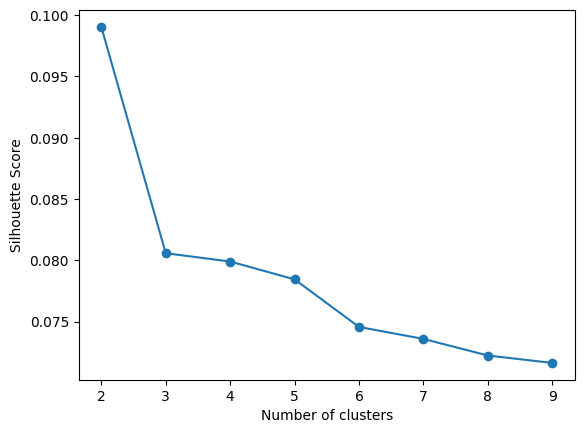

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

x = np.array(clean_train_df.loc[:, 'f_22':'f_28'])  # these are the only relevant float vars

# power transform integer vars to make them look more 'normal'
power = 0.47  # best value
x2 = ((1 + np.array(clean_train_df.loc[:, 'f_07':'f_13'])) ** power - 1) / power

# set range of cluster numbers to try
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9]

# calculate silhouette score for each number of clusters
silhouette_scores = []
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(np.concatenate([x2, x], axis=1))
    silhouette_avg = silhouette_score(np.concatenate([x2, x], axis=1), cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"For n_clusters = {n_clusters}, the average silhouette_score is : {silhouette_avg:.4f}")

# plot the silhouette scores
plt.plot(range_n_clusters, silhouette_scores, '-o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()


**Elbow curve to obtain the optimum value of k for kmeans clustering**

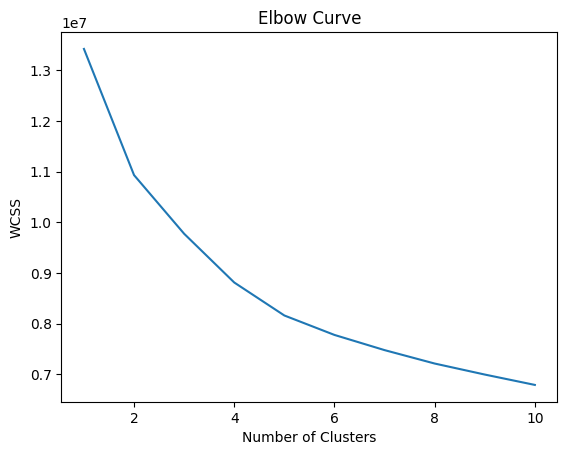

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# load the dataset
#data = pd.read_csv('data.csv')

# select the features

relevant_vars = ['f_07', 'f_08', 'f_09', 'f_10', 'f_11', 'f_12', 'f_13',
                 'f_22', 'f_23', 'f_24', 'f_25', 'f_26', 'f_27', 'f_28']
X = clean_train_df[relevant_vars]


# determine the optimal number of clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# plot the elbow curve
plt.plot(range(1, 11), wcss)
plt.title('Elbow Curve')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()


**Dimensionality reduction using PCA**

In [ ]:
from sklearn.decomposition import PCA
n_comp = 14
print('\nRunning PCA ...')
pca = PCA(n_components=n_comp, svd_solver='full', random_state=1001)
X_pca = pca.fit_transform(clean_train_df)
print('Explained variance: %.4f' % pca.explained_variance_ratio_.sum())
print('Individual variance contributions:')
for j in range(n_comp):
    print(pca.explained_variance_ratio_[j])


Running PCA ...
Explained variance: 0.9094
Individual variance contributions:
0.24606588011247887
0.15290545633728145
0.1396987491136184
0.08675347764377644
0.0797281056037967
0.07392384901516055
0.04175665934435493
0.01639060255810737
0.015669615495692374
0.013391228915468636
0.012356789575183581
0.011350616503190225
0.010119342033580602
0.009305087518183394


In [ ]:
# Lets visualize the reduced dimensions (29 to 15)
pca_cols = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca_df = pd.DataFrame(X_pca, columns=pca_cols, index=clean_train_df.index)
X_pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14
0,1.218485,5.728641,-3.454671,-7.766401,-0.724441,-2.063335,3.151984,0.353811,-2.026521,1.046583,1.332652,0.956584,1.114405,-1.090948
1,-4.726471,-0.871616,9.886862,-2.186396,2.890587,-1.483624,-1.378499,-0.594930,2.005907,-1.335982,0.935978,1.760904,-0.888887,-0.292072
2,-4.301884,1.370934,-3.306918,-0.378959,-5.665488,2.412370,0.707281,0.569103,1.308183,-0.772499,3.190985,-3.533131,-1.626037,1.331142
3,6.214906,1.695672,1.287391,0.237348,2.981726,1.378562,-0.733505,0.668781,1.590011,-0.381925,-1.956464,-1.546227,0.091473,-0.338604
4,-5.031382,-0.570695,8.559778,3.495286,-3.788974,-4.908504,0.220089,-0.067101,2.520795,-1.492413,0.297171,-1.281633,1.592555,0.224968


**Forming the 2 clusters using kmeans for this pca transformed data**

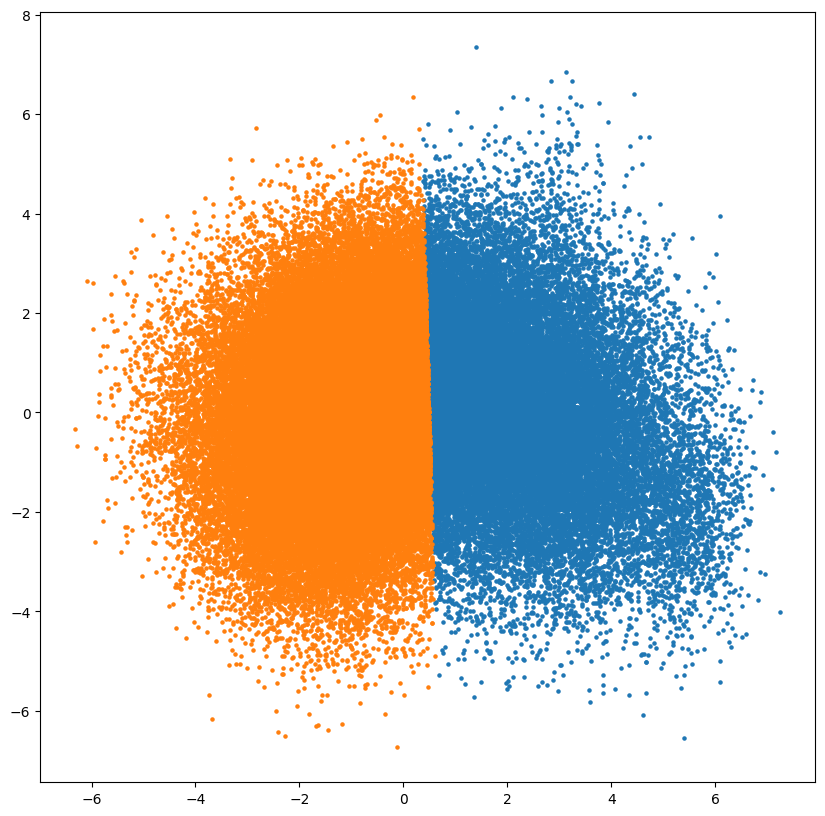

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
data=clean_train_df

# Select relevant features
X = data.loc[:, ['f_22', 'f_23', 'f_24', 'f_25', 'f_26', 'f_27', 'f_28']].values

# Apply power transform to integer features
power = 0.47
X_int = data.loc[:, ['f_07', 'f_08', 'f_09', 'f_10', 'f_11', 'f_12', 'f_13']].values
X_int = ((1 + X_int) ** power - 1) / power
X = np.concatenate([X, X_int], axis=1)

# Perform PCA to extract principal components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Cluster using k-means
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_pca)

# Plot the clusters
fig, ax = plt.subplots(figsize=(10, 10))
for i in range(2):
    idx = kmeans.labels_ == i
    ax.scatter(X_pca[idx, 0], X_pca[idx, 1], s=5)
plt.show()



**Using ICA to classify all the rows into these 2 clusters and returning the classification prediction query**

In [ ]:
from sklearn.decomposition import FastICA

ica = FastICA(n_components=2, random_state=42)
X_ica = ica.fit_transform(X_pca)

kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_ica)

print("Number of rows in cluster 0:", np.sum(kmeans.labels_ == 0))
print("Number of rows in cluster 1:", np.sum(kmeans.labels_ == 1))

row_42 = X_ica[41].reshape(1, -1)
cluster_42 = kmeans.predict(row_42)[0]
print("Row 42 belongs to cluster:", cluster_42)


Number of rows in cluster 0: 34276
Number of rows in cluster 1: 57136
Row 42 belongs to cluster: 1


**Using LDA to classify all the rows into these 2 clusters and returning the classification prediction query**

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
y = kmeans.labels_
lda = LinearDiscriminantAnalysis()
lda.fit(X_pca, y)
row_42 = X_pca[41].reshape(1, -1)
cluster_42 = lda.predict(row_42)[0]
print("Row 42 belongs to cluster:", cluster_42)
all_clusters = lda.predict(X_pca)

Row 42 belongs to cluster: 1


In [ ]:
cluster_labels = lda.predict(X_pca)

# Count number of rows in each cluster
num_rows_cluster1 = np.sum(cluster_labels == 0)
num_rows_cluster2 = np.sum(cluster_labels == 1)

print("Number of rows in Cluster 1:", num_rows_cluster1)
print("Number of rows in Cluster 2:", num_rows_cluster2)

Number of rows in Cluster 1: 30083
Number of rows in Cluster 2: 61329


**KNN to classify all the rows into these 2 clusters and then returning the classification prediction query**

**First finding the optimum number of n_neighbors**

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
n_neighbors_range = range(1, 11)
cv_scores = []
for n_neighbors in n_neighbors_range:
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    scores = cross_val_score(knn, X_pca, kmeans.labels_, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())
optimal_n_neighbors = n_neighbors_range[np.argmax(cv_scores)]
print("Optimum number of n_neighbors:", optimal_n_neighbors)


Optimum number of n_neighbors: 9


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_pca, kmeans.labels_, test_size=0.3, random_state=42)
knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
row_42 = X_pca[42].reshape(1, -1)
cluster_42 = knn.predict(row_42)
print(f"Row 42 belongs to cluster {cluster_42}")


Row 42 belongs to cluster [0]


In [ ]:
knn.fit(X_pca, kmeans.labels_)
cluster_labels = knn.predict(X_pca)
num_rows_cluster1 = np.sum(cluster_labels == 0)
num_rows_cluster2 = np.sum(cluster_labels == 1)

print("Number of rows in Cluster 1:", num_rows_cluster1)
print("Number of rows in Cluster 2:", num_rows_cluster2)

Number of rows in Cluster 1: 33126
Number of rows in Cluster 2: 58286


**The plot of the 5 fold CV Score for ICA, LDA and KNN as classifers**

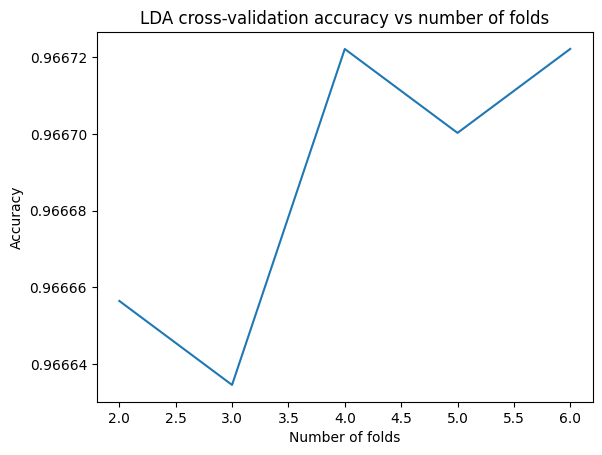

In [ ]:
kmeans.fit(X_pca)
y = kmeans.labels_
lda = LinearDiscriminantAnalysis()
cv_scores = []
num_folds = [2, 3, 4, 5, 6]
for n in num_folds:
    scores = cross_val_score(lda, X_pca, y, cv=n)
    cv_scores.append(np.mean(scores))
plt.plot(num_folds, cv_scores)
plt.xlabel('Number of folds')
plt.ylabel('Accuracy')
plt.title('LDA cross-validation accuracy vs number of folds')
plt.show()


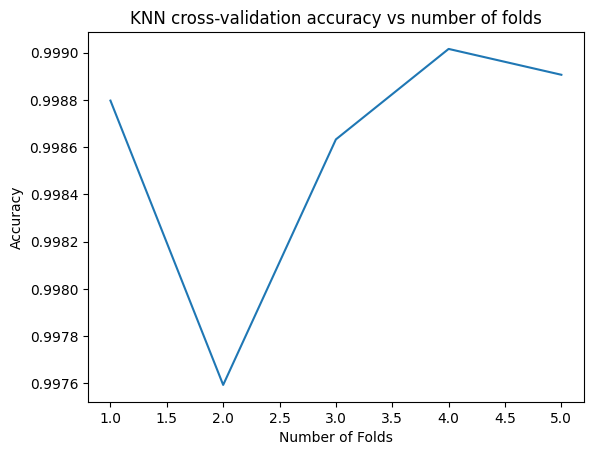

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

# Define the KNN classifier
knn = KNeighborsClassifier(n_neighbors=9)

# Perform 5-fold cross-validation and store the accuracy scores
cv_scores = cross_val_score(knn, X_pca, y, cv=5)

# Plot the accuracy vs number of folds
plt.plot(range(1,6), cv_scores)
plt.xlabel('Number of Folds')
plt.ylabel('Accuracy')
plt.title('KNN cross-validation accuracy vs number of folds')
plt.show()


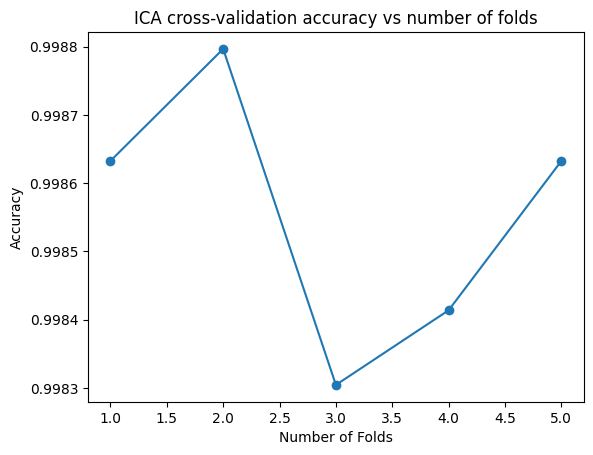

In [ ]:
ica = FastICA(n_components=2, random_state=42)
X_ica = ica.fit_transform(X_pca)

knn = KNeighborsClassifier(n_neighbors=9)
cv_scores = cross_val_score(knn, X_ica, kmeans.labels_, cv=5)

plt.plot(range(1, 6), cv_scores, marker='o')
plt.title('ICA cross-validation accuracy vs number of folds')
plt.xlabel('Number of Folds')
plt.ylabel('Accuracy')
plt.show()


In [ ]:
ica = FastICA(n_components=2, random_state=42)
X_ica = ica.fit_transform(X_pca)

knn = KNeighborsClassifier(n_neighbors=9)
cv_scores = cross_val_score(knn, X_ica, kmeans.labels_, cv=5)

plt.plot(range(1, 6), cv_scores, marker='o')
plt.title('ICA cross-validation accuracy vs number of folds')
plt.xlabel('Number of Folds')
plt.ylabel('Accuracy')
plt.show()
